# Car Classification using Convolutional Neural Networks
---
<br>

### Name and ID:
Yoav Gal: -
<br>
Guy Houri: -

# About
This notebook explores different approaches to car classification using end to end Convolutional Neural Networks (CNNs). The notebook is structured as follows:

1. **Installations** - Setting up the required libraries and dependencies
2. **Utilities** - Helper functions for data processing, visualization,model evaluation, and model training.
3. **Data Preparation** - Loading and preprocessing the Stanford Cars dataset (agmentation and manipulation for qiuck training)
4. **Experiment 1** -
5. **Experiment 2** -
6. **Experiment 3** -
7. **Save Model** - Saving the best performing model for future use
8. **Test envitoment** - A small test envitoment to try out our best model.

# Installations
This section contains all the necessary package installations required for this notebook.

In [3]:
%%capture
%pip install scipy matplotlib pillow numpy pandas tqdm torch torchvision scikit-learn gdown kagglehub openpyxl tk ipython-autotime ipython albumentations
%load_ext autotime
%load_ext autoreload

time: 60.3 ms (started: 2025-03-08 10:52:53 +02:00)


In [4]:
%%script echo skipping
!gdown 1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6 # stanford_cars.xlsx

skipping
time: 7.73 ms (started: 2025-03-08 10:52:53 +02:00)


In [5]:
import kagglehub
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")
path

/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2'

time: 417 ms (started: 2025-03-08 10:52:53 +02:00)


In [6]:
!mkdir ./content
!mkdir ./content/images/
!mkdir ./content/images/test
!mkdir ./content/images/train

mkdir: ./content: File exists
mkdir: ./content/images/: File exists
mkdir: ./content/images/test: File exists
mkdir: ./content/images/train: File exists
time: 939 ms (started: 2025-03-08 10:52:54 +02:00)


In [7]:
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/* ./content/images/test
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/* ./content/images/train
!mv /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat ./content/

zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_test/cars_test/*
zsh:1: no matches found: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_train/cars_train/*
mv: /Users/yoavgal/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/cars_annos.mat: No such file or directory
time: 692 ms (started: 2025-03-08 10:52:55 +02:00)


# Initial (one time) data preperation

In this section we will:

- Modify the dataset from 50/50 split to 70/30 split.
- Create and save images tensors once so that it can be used later without a lot of processing.

## Scope variables

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import shutil

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

## Dataset to 70/30

The inital data set contains 8000 images for 196 classes , thats only about 40 (assuming no validation set) images per class, this number is very small when tring to classify beween 196 classes, to help with that we will take some of the test data (with the class proprtion) and add it to the test to get an 11000 images (55 per class). 

*later on we would agument the images as well to have more "uniqe" traning data.

In [ ]:
!gdown 1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6 # original stanford_cars.xlsx

Downloading...
From: https://drive.google.com/uc?id=1Yp2acaCWG92n7_nfJjP-8WF8GE0BeVI6
To: /Users/yoavgal/code/car-classification/CNN-notebook/stanford_cars.xlsx
100%|████████████████████████████████████████| 686k/686k [00:00<00:00, 2.61MB/s]
time: 4.67 s (started: 2025-03-06 09:34:49 +02:00)


In [4]:
excel_path = 'stanford_cars.xlsx'
train_df = pd.read_excel(excel_path, sheet_name='train')
test_df = pd.read_excel(excel_path, sheet_name='test')

train_df['image'] = 'train/' + train_df['image']
test_df['image'] = 'test/' + test_df['image']

# Get class distribution in test set
test_class_counts = test_df['class'].value_counts(normalize=True)

# Select 40% of test data to move to train, stratified by class
test_to_move, test_to_keep = train_test_split(
    test_df, 
    test_size=0.6, 
    stratify=test_df['class'],
    random_state=42
)

# Verify the class distribution is maintained
moved_class_counts = test_to_move['class'].value_counts(normalize=True)
kept_class_counts = test_to_keep['class'].value_counts(normalize=True)


new_train_df = pd.concat([train_df, test_to_move], ignore_index=True)
new_test_df = test_to_keep.copy()
full_data_df = pd.concat([train_df, test_df], ignore_index=True)

# Also save as CSV for easier handling
new_train_df.to_csv('stanford_cars_train.csv', index=False)
new_test_df.to_csv('stanford_cars_test.csv', index=False)
full_data_df.to_csv('stanford_cars_full.csv', index=False)

print(f"Original train set: {len(train_df)} samples")
print(f"Original test set: {len(test_df)} samples")
print(f"Moved from test to train: {len(test_to_move)} samples")
print(f"New train set: {len(new_train_df)} samples")
print(f"New test set: {len(new_test_df)} samples")
print(f"Full data set: {len(full_data_df)} samples")

Original train set: 8144 samples
Original test set: 8041 samples
Moved from test to train: 3216 samples
New train set: 11360 samples
New test set: 4825 samples
Full data set: 16185 samples


## Normalize and agumantaition 

### Normalize:
Tensors are saved in a grayscale format:
 - saves memory (1 channel instead of 3 for RGB).
 - removes partly "color" noise - all cars can theoretically come in all colors, so color won't have anything to do with the car type.

We save the tensors in a 160X160 (25k) resolution, which is half the size of 224X224 (50k) for faster training.

By taking these steps, we made our training time to process 1 image 6 (2X3) times faster, for a bit less quality for the images, a great trade-off where compute is our main bottleneck.


In [18]:
def grayscale_normalization(output_size=(160, 160)):
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(output_size,interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor()
    ])

time: 577 μs (started: 2025-03-07 08:25:25 +02:00)


### Agumantaition
Do to the small size of the dataset we decided to augment some data so the we would have a bigger traning set and try to generalize better.

| Augmentation Type | Probability | Parameters/Effects |
|-------------------|-------------|-------------------|
| HorizontalFlip | 50% | Mirrors image horizontally |
| RandomAffine | 50% | Rotation: ±15°<br>Translation: ±10%<br>Scale: 0.9-1.1x |
| ColorJitter | 33% | Brightness: ±20%<br>Contrast: ±20% |
| GaussianBlur | 20% | Kernel size: 3x7 pixels |

![example](https://miro.medium.com/max/1400/0*0Je9h2iT9m7ribFJ.png)

In [19]:
def agumantaitionCreator(output_size=(160, 160)):
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
        ], p=0.5),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ], p=0.33),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=(3, 7))
        ], p=0.2),
        transforms.Resize(output_size,interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
    ])

time: 639 μs (started: 2025-03-07 08:25:25 +02:00)


## Build tensors


### No Augmentations

In [9]:
def csv_to_tensors(csv_path, img_dir,output_size=(160, 160)): 
    df = pd.read_csv(csv_path)
    transform = grayscale_normalization(output_size=output_size)
    
    images = []
    labels = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(img_dir, row['image'])
        try:
            img = Image.open(img_path)
            img_tensor = transform(img)
            
            images.append(img_tensor)
            labels.append(row['class'] - 1)  # 0-based indexing
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    
    print(f"Images tensor shape: {images_tensor.shape} Image tensors labels shape: {labels_tensor.shape}" )
    return images_tensor, labels_tensor


### With Augmentations

In [330]:
def csv_to_augmented_tensors(csv_path, img_dir, aug_ratio=3, output_size=(160, 160)):
    df = pd.read_csv(csv_path)
    transform = grayscale_normalization(output_size=output_size)
    aug_transform = agumantaitionCreator(output_size=output_size)
    images = []
    labels = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing original images"):
        img_path = os.path.join(img_dir, row['image'])
        try:
            # Original image
            img = Image.open(img_path)
            img_tensor = transform(img)
            images.append(img_tensor)
            labels.append(row['class'] - 1)
            
            # Augmented versions
            for _ in range(aug_ratio):
                og_img = Image.open(img_path)
                augmented_tensor = aug_transform(og_img)
                images.append(augmented_tensor)
                labels.append(row['class'] - 1)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    images_tensor = torch.stack(images)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    
    print(f"Final dataset size - Images: {images_tensor.shape}, Labels: {labels_tensor.shape}")
    return images_tensor, labels_tensor


time: 935 μs (started: 2025-03-06 19:28:32 +02:00)


### Save the tensors

In [7]:
def save_tensors_zip(tensors, output_path):
    os.makedirs(output_path, exist_ok=True)

    images_tensor, labels_tensor = tensors
    torch.save(images_tensor, os.path.join(output_path, 'images.pt'))
    torch.save(labels_tensor, os.path.join(output_path, 'labels.pt'))
    
    test = shutil.make_archive(output_path, 'zip', output_path)
    print(f"tensors saverd to {test}")

In [21]:
# %%script echo skipping
# train_tensors = csv_to_augmented_tensors(
#     'stanford_cars_train.csv',
#     './content/images',
#     aug_ratio=3,
# )
# save_tensors_zip(train_tensors, './content/train_tensors')

# test_tensors = csv_to_tensors(
#     'stanford_cars_test.csv',
#     './content/images',
#     output_size=(160, 160)
# )
# save_tensors_zip(test_tensors, './content/test_tensors')

full_tensors = csv_to_tensors(
    'stanford_cars_full.csv',
    './content/images',
    output_size=(160, 160)
)
save_tensors_zip(full_tensors, './content/full_tensors')

100%|██████████| 16185/16185 [00:38<00:00, 425.22it/s]


Images tensor shape: torch.Size([16185, 1, 160, 160]) Image tensors labels shape: torch.Size([16185])
tensors saverd to /Users/yoavgal/code/car-classification/CNN-notebook/content/full_tensors.zip
time: 1min 23s (started: 2025-03-07 08:25:41 +02:00)


# Utilities
Helper functions for:
- Imports for context
- Data loading and preprocessing
- Visualization of images and results
- Model evaluation metrics
- Training and validation loops

## Imports and loading

In [8]:
%%capture
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
import textwrap
from collections import Counter
from tqdm import tqdm
from typing import Optional, List, Tuple, Callable, Union
import pickle
import random
import tempfile
import zipfile
import albumentations as A

import torch
import torchvision.models as models
import torch.multiprocessing as mp
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize

import tkinter as tk
from tkinter import filedialog
from torch.utils.data import WeightedRandomSampler


time: 2.98 s (started: 2025-03-08 10:53:06 +02:00)


Load the tensors (update to gdown first in colab)

In [9]:
def load_tensors_from_zip(zip_path):
    with tempfile.TemporaryDirectory() as temp_dir:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)
            
        images = torch.load(os.path.join(temp_dir, 'images.pt'),map_location="cpu")
        labels = torch.load(os.path.join(temp_dir, 'labels.pt'),map_location="cpu")
        
        print("\n" + "="*50)
        print(f"Loaded Tensors from: {os.path.basename(zip_path)}")
        print("="*50)
        print(f"Images Shape: {images.shape}")
        print(f"Labels Shape: {labels.shape}")
        print(f"Number of Classes: {len(torch.unique(labels))}")
        print(f"Memory Usage: {images.element_size() * images.nelement() / 1024 / 1024:.2f} MB")
        print("="*50 + "\n")
        
        return images, labels

time: 622 μs (started: 2025-03-08 10:53:09 +02:00)


## Saving and Testing

In [10]:
def save_best_model(model: nn.Module, model_filename: str) -> None:
  # Create a directory for saving models if it doesn't exist
  save_dir = os.path.join(os.getcwd(), "./saved_models")
  os.makedirs(save_dir, exist_ok=True)
  
  # Save the model locally
  save_path = os.path.join(save_dir, model_filename)
  torch.save(model.state_dict(), save_path)
  print(f"Model saved to {save_path}")

time: 413 μs (started: 2025-03-08 10:53:09 +02:00)


## Informational

In [11]:
def print_params_count(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_params}")

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {trainable_params}")

time: 448 μs (started: 2025-03-08 10:53:09 +02:00)


## Display images

In [12]:
# CAN BE REMOVED!
def display_augmented_tensors(images, indices, transform, num_augmentations=3, figsize=(15, 5)):
    """
    Display original tensor images and their augmented versions.
    
    Args:
        images: Tensor of shape [N, C, H, W]
        indices: List of indices to display
        transform: Albumentations transform pipeline
        num_augmentations: Number of augmented versions to show for each image
        figsize: Size of the figure (width, height)
    """
    num_images = len(indices)
    fig, axes = plt.subplots(num_images, num_augmentations + 1, figsize=figsize)
    
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(indices):
        # Get original image and convert to numpy
        original_image = images[idx].squeeze().numpy()
        axes[row, 0].imshow(original_image, cmap='gray')
        axes[row, 0].set_title('Original')
        axes[row, 0].axis('off')
        
        # Get augmented versions
        for col in range(num_augmentations):
            # Apply transform multiple times
            augmented = transform(image=original_image)['image']
            if isinstance(augmented, torch.Tensor):
                augmented = augmented.squeeze().numpy()
            
            axes[row, col + 1].imshow(augmented, cmap='gray')
            axes[row, col + 1].set_title(f'Augmented {col + 1}')
            axes[row, col + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

time: 731 μs (started: 2025-03-08 10:53:09 +02:00)


## Training Utils


### validate

In [13]:
def validate(model: nn.Module, val_loader: DataLoader, device: torch.device, criterion: nn.Module) -> Tuple[float, float]:
  """
    Returns:
        Tuple[float, float]: A tuple containing the validation accuracy and average loss.
  """
  model.eval()
  correct = 0
  total = 0
  running_loss = 0.0

  with torch.no_grad():
        # validation_process = tqdm(val_loader, desc='Validating', leave=False)
        for images, labels in val_loader:  
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  avg_loss = running_loss / len(val_loader)

  return accuracy, avg_loss

time: 593 μs (started: 2025-03-08 10:53:09 +02:00)


### visualize_results

In [14]:
def visualize_results(train_losses: List[float], val_losses: List[float], train_accuracies: List[float], val_accuracies: List[float]) -> None:
    """
    Args:
        train_losses (List[float]): List of training loss values for each epoch.
        val_losses (List[float]): List of validation loss values for each epoch.
        train_accuracies (List[float]): List of training accuracy values for each epoch.
        val_accuracies (List[float]): List of validation accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Plot for Loss
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Training vs. Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)  # Plot for Accuracy
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Training vs. Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

time: 547 μs (started: 2025-03-08 10:53:09 +02:00)


### generate_classification_report

In [38]:
def generate_classification_report(model: nn.Module, data_loader: DataLoader, device: torch.device) -> None:
    y_true: List[int] = []
    y_pred: List[int] = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    return accuracy, f1, precision, recall

time: 22.7 ms (started: 2025-03-08 11:58:56 +02:00)


### training_loop

In [16]:
def training_loop(
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    metric_fn: Optional[Callable[[float, float], float]] = None,
    is_clip: bool = False,
    clip_value: float = 1.0,
    is_l1: bool = False,
    l1_regularization_strength: float = 0.001, # Added parameter for L1 regularization strength
    none_blocking: bool = False,
    ) -> Tuple[List[float], List[float], List[float], List[float]]:

    # Lists to store training and validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    clip_fn = torch.nn.utils.clip_grad_norm_ if is_clip else None

    # Training and validation loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False) 

        for images, labels in train_loop:
            images, labels = images.to(device, non_blocking=none_blocking), labels.to(device, non_blocking=none_blocking)

            optimizer.zero_grad(set_to_none=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            if is_l1:
              l1_loss = model.calculate_l1_loss(l1_regularization_strength)
              total_loss = loss + l1_loss
              total_loss.backward()
            else:
              loss.backward()

            if clip_fn:
                clip_fn(model.parameters(), clip_value)

            optimizer.step()

            running_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Store training metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        val_accuracy, val_loss = validate(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  # For ReduceLROnPlateau
            else:
                scheduler.step()  # For other schedulersz
        print(f"Epoch {epoch+1}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

time: 1.35 ms (started: 2025-03-08 10:53:09 +02:00)


# Data Preparation
In this section, we will:
- Load the Stanford Cars dataset
- Explore the dataset characteristics
- Preprocess the images (resizing, normalization, etc.)
- Split the data into training, validation, and test sets

## Global variables

In [17]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
train_images, train_labels = load_tensors_from_zip('./content/train_tensors.zip')
test_images, test_labels = load_tensors_from_zip('./content/test_tensors.zip')
batch_size = 64
num_workers=4


Loaded Tensors from: train_tensors.zip
Images Shape: torch.Size([45440, 1, 160, 160])
Labels Shape: torch.Size([45440])
Number of Classes: 196
Memory Usage: 4437.50 MB


Loaded Tensors from: test_tensors.zip
Images Shape: torch.Size([4825, 1, 160, 160])
Labels Shape: torch.Size([4825])
Number of Classes: 196
Memory Usage: 471.19 MB

time: 11.3 s (started: 2025-03-08 10:53:13 +02:00)


## CarDataset

In [18]:
class CarDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # if self.transform:
        #    if torch.is_tensor(image):
        #       image = image.squeeze().numpy()
        #    transformed = self.transform(image=image)
        #    image = transformed['image'] 
     
        # if not torch.is_tensor(image):
        #     image = torch.from_numpy(image)
        
            
        return image, label

time: 634 μs (started: 2025-03-08 10:53:24 +02:00)


## Data Loaders

In [19]:
def create_train_val_loaders(train_images, train_labels, val_size=0.15, batch_size=batch_size, num_workers=num_workers, seed=42):
    torch.manual_seed(seed)
    dataset_size = len(train_labels)
    val_length = int(dataset_size * val_size)
    train_length = dataset_size - val_length
    
    full_train_dataset = CarDataset(
        train_images, 
        train_labels,
    )
    
    train_subset, val_subset = random_split(
        full_train_dataset, 
        [train_length, val_length],
        generator=torch.Generator().manual_seed(seed)
    )
    
    # train_subset.dataset.transform = train_transform 
    

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        # sampler=create_sampler_with_weighted_sampler(train_subset.dataset.labels),
        # num_workers=num_workers,
        # persistent_workers=True,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=num_workers,
        # persistent_workers=True,
        pin_memory=True
    )
    
    print("\n" + "="*50)
    print("Data Split Information")
    print("="*50)
    print(f"Total dataset size: {dataset_size}")
    print(f"Training set size: {train_length}")
    print(f"Validation set size: {val_length}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print("="*50 + "\n")
    
    return train_loader, val_loader


time: 687 μs (started: 2025-03-08 10:53:24 +02:00)


In [20]:
%autoreload 2

import data_utils as du

if __name__ == '__main__':
    train_loader, val_loader = du.create_train_val_loaders(train_images, train_labels, batch_size=64, num_workers=3)

    test_dataset = du.CarDataset(test_images, test_labels)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True
    )


Data Split Information
Batch size: 64
Number of workers: 3
Total dataset size: 45440
Training set size: 38624
Validation set size: 6816
Number of training batches: 604
Number of validation batches: 107

time: 9.76 ms (started: 2025-03-08 10:53:24 +02:00)


# Experiment 1: Basic CNN Architecture with GAP and MP:

**Architecture:**

*   **Sequential Convolutional Feature Extraction:**
    *   Four convolutional layers with increasing filter counts (8, 16, 32, 64) extract features from grayscale input images (1 input channel).  Each convolution uses a 3x3 kernel and 'same' padding. Batch normalization and ReLU activation follow each convolution.
*   **Max Pooling for Downsampling: (MP):**
    *   2x2 max pooling layers, with a stride of 2, follow each convolutional block, reducing spatial dimensions and computational cost.
*   **Global Average Pooling (GAP):**
    *   Global average pooling summarizes each final feature map into a single value, resulting in a 64-element feature vector.
*   **Fully Connected Classification:**
    *   A fully connected layer maps the 64-element GAP output to the `num_classes` (196) output logits, followed by a log softmax activation for classification.

**Training and Hyperparameters:**

*   **Optimizer:** Adam
*   **Learning Rate:** 0.01
*   **Loss Function:** Cross-Entropy Loss
*   **Epochs:** 20
*  **Additional Notes:** Gradient clipping was used, utilizing PyTorch's `none_blocking=True` for data transfer optimization.

In [51]:
class Basic_CNN_GAP_MP(nn.Module):
    def __init__(self, num_classes=196):
        super(Basic_CNN_GAP_MP, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling Layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output size of (1, 1)

        # Final classification layer
        self.fc = nn.Linear(64, num_classes)  # Input is now just the number of channels

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Apply Global Average Pooling
        x = self.gap(x)
        x = torch.flatten(x, 1)

        # Classification
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x
# Create an instance of the model
cnn_exp_1_model= Basic_CNN_GAP_MP()
cnn_exp_1_model.to(device)
print_params_count(cnn_exp_1_model)

Total number of parameters: 37364
Total number of trainable parameters: 37364
time: 34.8 ms (started: 2025-03-08 09:17:27 +02:00)


Epoch [1/40], Loss: 1.5394, Validation Loss: 2.8810, Validation Accuracy: 37.94%


Epoch [2/40], Loss: 1.5160, Validation Loss: 2.5730, Validation Accuracy: 41.02%


Epoch [3/40], Loss: 1.5116, Validation Loss: 2.3874, Validation Accuracy: 43.62%


Epoch [4/40], Loss: 1.4894, Validation Loss: 2.4495, Validation Accuracy: 42.34%


Epoch [5/40], Loss: 1.4921, Validation Loss: 2.5936, Validation Accuracy: 41.52%


Epoch [6/40], Loss: 1.4837, Validation Loss: 2.6592, Validation Accuracy: 39.89%


Epoch [7/40], Loss: 1.4793, Validation Loss: 2.7074, Validation Accuracy: 39.66%


Epoch [8/40], Loss: 1.4718, Validation Loss: 2.6606, Validation Accuracy: 39.38%


Epoch [9/40], Loss: 1.4558, Validation Loss: 2.5939, Validation Accuracy: 41.15%


Epoch [10/40], Loss: 1.4545, Validation Loss: 2.8530, Validation Accuracy: 38.06%


Epoch [11/40], Loss: 1.4549, Validation Loss: 2.4598, Validation Accuracy: 42.99%


Epoch [12/40], Loss: 1.4447, Validation Loss: 2.6349, Validation Accuracy: 39.03%


Epoch [13/40], Loss: 1.4357, Validation Loss: 2.4757, Validation Accuracy: 42.34%


Epoch [14/40], Loss: 1.4217, Validation Loss: 2.7155, Validation Accuracy: 40.01%


Epoch [15/40], Loss: 1.4147, Validation Loss: 2.4439, Validation Accuracy: 43.82%


Epoch [16/40], Loss: 1.4116, Validation Loss: 2.8183, Validation Accuracy: 40.33%


Epoch [17/40], Loss: 1.3997, Validation Loss: 2.5373, Validation Accuracy: 42.68%


Epoch [18/40], Loss: 1.4005, Validation Loss: 2.8006, Validation Accuracy: 39.08%


Epoch [19/40], Loss: 1.3922, Validation Loss: 2.4324, Validation Accuracy: 44.35%


Epoch [20/40], Loss: 1.3806, Validation Loss: 2.7046, Validation Accuracy: 39.99%


Epoch [21/40], Loss: 1.3800, Validation Loss: 2.5607, Validation Accuracy: 41.59%


Epoch [22/40], Loss: 1.3776, Validation Loss: 2.4425, Validation Accuracy: 43.54%


Epoch [23/40], Loss: 1.3723, Validation Loss: 2.6368, Validation Accuracy: 41.18%


Epoch [24/40], Loss: 1.3690, Validation Loss: 2.7137, Validation Accuracy: 39.54%


Epoch [25/40], Loss: 1.3579, Validation Loss: 2.9524, Validation Accuracy: 37.44%


Epoch [26/40], Loss: 1.3638, Validation Loss: 2.7501, Validation Accuracy: 40.99%


Epoch [27/40], Loss: 1.3472, Validation Loss: 2.6827, Validation Accuracy: 41.53%


Epoch [28/40], Loss: 1.3451, Validation Loss: 2.7016, Validation Accuracy: 38.09%


Epoch [29/40], Loss: 1.3372, Validation Loss: 2.6564, Validation Accuracy: 41.65%


Epoch [30/40], Loss: 1.3305, Validation Loss: 2.5430, Validation Accuracy: 43.81%


Epoch [31/40], Loss: 1.3275, Validation Loss: 2.4698, Validation Accuracy: 43.47%


Epoch [32/40], Loss: 1.3175, Validation Loss: 2.4227, Validation Accuracy: 43.88%


Epoch [33/40], Loss: 1.3111, Validation Loss: 2.6534, Validation Accuracy: 42.61%


Epoch [34/40], Loss: 1.3012, Validation Loss: 2.4596, Validation Accuracy: 44.16%


Epoch [35/40], Loss: 1.3110, Validation Loss: 2.6455, Validation Accuracy: 41.52%


Epoch [36/40], Loss: 1.2987, Validation Loss: 2.6751, Validation Accuracy: 42.18%


Epoch [37/40], Loss: 1.2966, Validation Loss: 2.7543, Validation Accuracy: 39.83%


Epoch [38/40], Loss: 1.2897, Validation Loss: 2.6164, Validation Accuracy: 41.65%


Epoch [39/40], Loss: 1.2950, Validation Loss: 2.4729, Validation Accuracy: 44.16%


Epoch [40/40], Loss: 1.2887, Validation Loss: 3.0782, Validation Accuracy: 38.67%


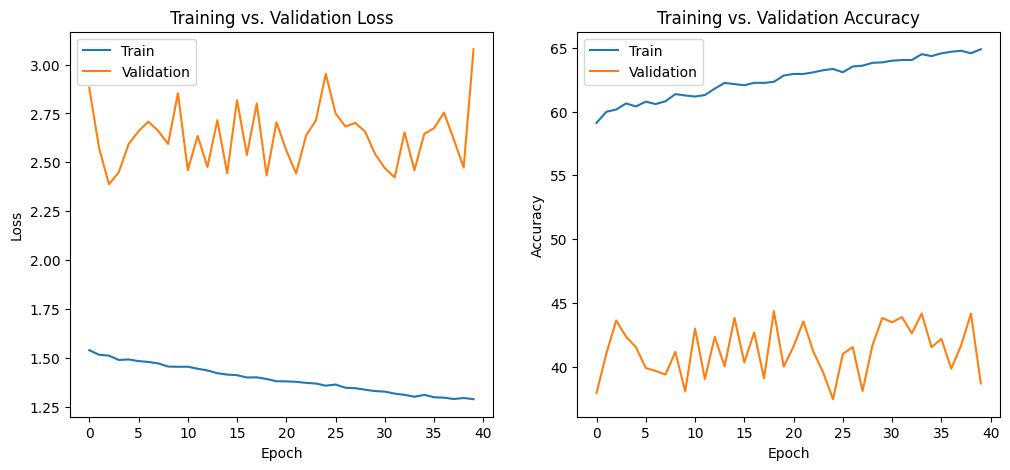

Accuracy: 0.2647
F1 Score: 0.2647
Precision: 0.3317
Recall: 0.2647
time: 10min 7s (started: 2025-03-08 09:39:14 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
epochs=80 #did not plato 80
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_exp_1_model.parameters(), lr)

train_loss, val_loss, train_acc, val_acc = training_loop(
    cnn_exp_1_model, optimizer, criterion, epochs, train_loader, val_loader, is_clip=True ,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
accuracy, f1, precision, recall = generate_classification_report(cnn_exp_1_model, test_loader, device)

In [ ]:
model_filename = f"last-exp-1-reust-{accuracy:.2f}"
save_best_model(cnn_exp_1_model,model_filename)



# Experiment 2 - QuickTrain - Model Architecture designed for speed and efficiency.

This model, `QuickTrain`, is designed for efficient image classification, prioritizing speed and ease of training even on resource-constrained hardware like a standard laptop. It achieves this through a compact architecture inspired by MobileNet principles.

**Architecture:**

*   **Depthwise Separable Convolutions:** The core building block is the depthwise separable convolution. This significantly reduces the number of parameters and computations compared to standard convolutions, contributing to the model's speed and efficiency.
*   **Initial Downsampling:** Aggressive downsampling is performed early in the network using a strided convolution (`stride=2`) in the first layer.
* **Max Pooling Blocks:** The network is structured into blocks, each consisting of two depthwise separable convolutions followed by a 2x2 max pooling layer. This progressively reduces spatial dimensions, controlling computational cost and increasing the receptive field.
* **Global Pooling Choice:** The model offers a choice between Global Average Pooling (GAP) and Global Max Pooling before the final classification layer.  By default, Global Max Pooling is used. This choice allows flexibility in how feature maps are summarized.
*   **Regularization:**
    *   Batch normalization is applied after each convolutional layer to stabilize training and improve generalization.
    *   Dropout (rate of 0.3) is used before the fully connected layers to further prevent overfitting.
*   **Two-Layer Fully Connected Classifier:** A two-layer fully connected network (32 -> 64 -> `num_classes`) performs the final classification, providing increased capacity compared to a single linear layer.
* **Small Footprint**: The model was built to be small and easy to train on laptops and normal CPUs.

**Training and Hyperparameters:**

*   **Optimizer:** AdamW (Adam with weight decay)
*   **Learning Rate:** 0.06 (3e-2)
*   **Loss Function:** Cross-Entropy Loss
*   **Epochs:** 10
*   **Scheduler:** CosineAnnealingWarmRestarts (T_0=10, T_mult=2, eta_min=1e-5) - This learning rate scheduler helps to find a better minimum and potentially escape local minima during training.
* **Weight Decay**: 1e-4 added in the optimizer for regularization
*   **Additional Notes:** Gradient clipping is used during training. PyTorch's `none_blocking=True` is utilized for optimized data transfer between CPU and GPU (if available).

In [21]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.bn_dw = nn.BatchNorm2d(in_channels)
        self.bn_pw = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn_dw(self.depthwise(x)))
        x = F.relu(self.bn_pw(self.pointwise(x)))
        return x

class QuickTrain(nn.Module):
    def __init__(self, num_classes=196, pooling_method="MAX"):  # Default to Max Pooling
        super(QuickTrain, self).__init__()
        self.pooling_method = pooling_method

        # Aggressive downsampling in the first layer
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.block1 = self._make_block(8, 16)
        self.block2 = self._make_block(16, 24)
        self.block3 = self._make_block(24, 32)

        # Choose pooling type using a cleaner ternary expression
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1)) if self.pooling_method == "MAX" else nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32, 64) 
        self.fc2 = nn.Linear(64, num_classes)


    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, 3, stride=1, padding=1),
            DepthwiseSeparableConv(out_channels, out_channels, 3, stride=1, padding=1),
            nn.MaxPool2d(2, 2) 
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

qiuck_train_model = QuickTrain()
qiuck_train_model.to(device)
print_params_count(qiuck_train_model)

Total number of parameters: 19956
Total number of trainable parameters: 19956
time: 91.6 ms (started: 2025-03-08 10:53:35 +02:00)


Epoch 1, Learning Rate: 0.000976
Epoch [1/30], Loss: 5.0006, Validation Loss: 4.9527, Validation Accuracy: 2.20%


Epoch 2, Learning Rate: 0.000905
Epoch [2/30], Loss: 4.9396, Validation Loss: 4.9020, Validation Accuracy: 2.63%


Epoch 3, Learning Rate: 0.000796
Epoch [3/30], Loss: 4.8882, Validation Loss: 4.8568, Validation Accuracy: 2.64%


Epoch 4, Learning Rate: 0.000658
Epoch [4/30], Loss: 4.8360, Validation Loss: 4.8243, Validation Accuracy: 3.29%


Epoch 5, Learning Rate: 0.000505
Epoch [5/30], Loss: 4.7962, Validation Loss: 4.7769, Validation Accuracy: 3.48%


Epoch 6, Learning Rate: 0.000352
Epoch [6/30], Loss: 4.7602, Validation Loss: 4.7426, Validation Accuracy: 3.70%


Epoch 7, Learning Rate: 0.000214
Epoch [7/30], Loss: 4.7322, Validation Loss: 4.7250, Validation Accuracy: 3.73%


Epoch 8, Learning Rate: 0.000105
Epoch [8/30], Loss: 4.7067, Validation Loss: 4.7089, Validation Accuracy: 3.87%


Epoch 9, Learning Rate: 0.000034
Epoch [9/30], Loss: 4.6874, Validation Loss: 4.7000, Validation Accuracy: 3.99%


Epoch 10, Learning Rate: 0.001000
Epoch [10/30], Loss: 4.6800, Validation Loss: 4.6966, Validation Accuracy: 3.98%


Epoch 11, Learning Rate: 0.000994
Epoch [11/30], Loss: 4.7239, Validation Loss: 4.7346, Validation Accuracy: 3.46%


Epoch 12, Learning Rate: 0.000976
Epoch [12/30], Loss: 4.6891, Validation Loss: 4.6505, Validation Accuracy: 4.31%


Epoch 13, Learning Rate: 0.000946
Epoch [13/30], Loss: 4.6469, Validation Loss: 4.6440, Validation Accuracy: 4.39%


Epoch 14, Learning Rate: 0.000905
Epoch [14/30], Loss: 4.6025, Validation Loss: 4.6051, Validation Accuracy: 4.47%


Epoch 15, Learning Rate: 0.000855
Epoch [15/30], Loss: 4.5558, Validation Loss: 4.5610, Validation Accuracy: 4.96%


Epoch 16, Learning Rate: 0.000796
Epoch [16/30], Loss: 4.5118, Validation Loss: 4.4996, Validation Accuracy: 5.36%


Epoch 17, Learning Rate: 0.000730
Epoch [17/30], Loss: 4.4760, Validation Loss: 4.4512, Validation Accuracy: 5.97%


Epoch 18, Learning Rate: 0.000658
Epoch [18/30], Loss: 4.4405, Validation Loss: 4.4223, Validation Accuracy: 5.90%


Epoch 19, Learning Rate: 0.000582
Epoch [19/30], Loss: 4.4068, Validation Loss: 4.4292, Validation Accuracy: 5.85%


Epoch 20, Learning Rate: 0.000505
Epoch [20/30], Loss: 4.3749, Validation Loss: 4.3627, Validation Accuracy: 7.03%


Epoch 21, Learning Rate: 0.000428
Epoch [21/30], Loss: 4.3475, Validation Loss: 4.3388, Validation Accuracy: 7.17%


Epoch 22, Learning Rate: 0.000352
Epoch [22/30], Loss: 4.3265, Validation Loss: 4.3177, Validation Accuracy: 7.42%


Epoch 23, Learning Rate: 0.000280
Epoch [23/30], Loss: 4.3023, Validation Loss: 4.3220, Validation Accuracy: 7.22%


Epoch 24, Learning Rate: 0.000214
Epoch [24/30], Loss: 4.2899, Validation Loss: 4.2988, Validation Accuracy: 7.67%


Epoch 25, Learning Rate: 0.000155
Epoch [25/30], Loss: 4.2725, Validation Loss: 4.2790, Validation Accuracy: 7.88%


Epoch 26, Learning Rate: 0.000105
Epoch [26/30], Loss: 4.2621, Validation Loss: 4.2706, Validation Accuracy: 7.91%


Epoch 27, Learning Rate: 0.000064
Epoch [27/30], Loss: 4.2542, Validation Loss: 4.2664, Validation Accuracy: 7.86%


Epoch 28, Learning Rate: 0.000034
Epoch [28/30], Loss: 4.2499, Validation Loss: 4.2701, Validation Accuracy: 7.88%


Epoch 29, Learning Rate: 0.000016
Epoch [29/30], Loss: 4.2379, Validation Loss: 4.2639, Validation Accuracy: 8.23%


Epoch 30, Learning Rate: 0.001000
Epoch [30/30], Loss: 4.2320, Validation Loss: 4.2553, Validation Accuracy: 8.20%


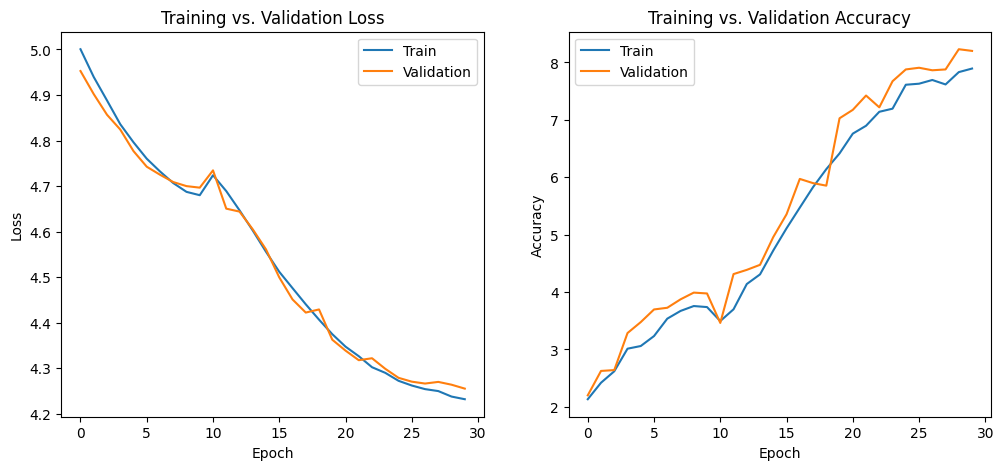

Accuracy: 0.0763
F1 Score: 0.0609
Precision: 0.0680
Recall: 0.0763
time: 10min 43s (started: 2025-03-08 11:01:11 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
epochs=30
lr=1e-3

optimizer = optim.AdamW(qiuck_train_model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

train_loss, val_loss, train_acc, val_acc = training_loop(
    qiuck_train_model, optimizer, criterion, epochs, train_loader, val_loader,scheduler=scheduler, is_clip=True,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
accuracy, f1, precision, recall = generate_classification_report(qiuck_train_model, test_loader, device)

In [ ]:
model_filename = f"last-exp-2-reust-{accuracy:.2f}"
save_best_model(qiuck_train_model,model_filename)

# Experiment 3 - BiggerIsBetter? - A bigger and deepr version of the QuickTrain model

This model, `BiggerIsBetter`, is a refined (bigger and deeper) version of the `QiuckTrain`.

**Architecture:**

*   **Four Convolutional Blocks:** The core of the network consists of four convolutional blocks.  Each block contains two depthwise separable convolutions.
    *   **Downsampling within Blocks:** Downsampling (stride=2) is integrated into the *first* depthwise separable convolution of the *first three* blocks. The last block dose *not* downsample. This eliminates the need for separate `MaxPool2d` layers within the blocks, streamlining the architecture.
    *   **Consistent Channel Doubling:** The number of channels doubles consistently across the first three blocks (12 -> 24 -> 48 -> 96), ending at 192 in the fourth block.

*   **Global Pooling Choice:** The model supports either Global Average Pooling (GAP) or Global Max Pooling before the final classification layer, with Max Pooling as the default.  This provides flexibility in how feature maps are summarized.

*   **Regularization:**
    *   Batch normalization is applied after each convolutional layer and before the ReLU activation in the fully connected layers, promoting stable training and better generalization.
    *   Dropout (rate of 0.4) is used after the global pooling layer and *between* the fully connected layers to prevent overfitting.

*   **Three Fully Connected Layers:**  A three-layer fully connected network (192 -> 128 -> 64 -> `num_classes`) performs the final classification. The smaller size of these layers, compared to previous versions, contributes to the model's overall efficiency.

**Training and Hyperparameters:**

*   **Optimizer:** AdamW (Adam with weight decay)
*   **Learning Rate:** 1e-3 (0.001)
*   **Loss Function:** Cross-Entropy Loss
*   **Epochs:** 20 
*   **Scheduler:** CosineAnnealingWarmRestarts (T_0=10, T_mult=2, eta_min=1e-5) - This learning rate scheduler helps to improve training by cyclically varying the learning rate.
*   **Weight Decay:** 1e-4 (included in the AdamW optimizer) - Provides L2 regularization.
*   **Additional Notes:** Gradient clipping is used during training. PyTorch's `none_blocking=True` is utilized for optimized data transfer (if using a GPU).


In [34]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.bn_dw = nn.BatchNorm2d(in_channels)
        self.bn_pw = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn_dw(self.depthwise(x)))
        x = F.relu(self.bn_pw(self.pointwise(x)))
        return x

class BiggerIsBetter(nn.Module):
    def __init__(self, num_classes=196, pooling_method="MAX"):
        super(BiggerIsBetter, self).__init__()
        self.pooling_method = pooling_method

        # Start with 12 channels, initial downsampling
        self.conv1 = nn.Conv2d(1, 12, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(12)

        # Four blocks, consistent channel doubling
        self.block1 = self._make_block(12, 24, stride=2)
        self.block2 = self._make_block(24, 48, stride=2)
        self.block3 = self._make_block(48, 96, stride=2)
        self.block4 = self._make_block(96, 192, stride=1) # No downsampling in the last block

        # Global Pooling (Max or Avg)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1)) if self.pooling_method == "MAX" else nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.4)

        # Three smaller FC layers
        self.fc1 = nn.Linear(192, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)

    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            DepthwiseSeparableConv(in_channels, out_channels, 3, stride=stride, padding=1),
            DepthwiseSeparableConv(out_channels, out_channels, 3, stride=1, padding=1),
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout(x) # added another dropout
        x = self.fc3(x)
        return x

bigger_model = BiggerIsBetter(num_classes=196, pooling_method="MAX")
bigger_model.to(device) 
print_params_count(bigger_model)

Total number of parameters: 128308
Total number of trainable parameters: 128308
time: 57.9 ms (started: 2025-03-08 11:36:47 +02:00)


Epoch 1, Learning Rate: 0.000976
Epoch [1/15], Loss: 3.6791, Validation Loss: 3.8834, Validation Accuracy: 11.44%


Epoch 2, Learning Rate: 0.000905
Epoch [2/15], Loss: 3.6508, Validation Loss: 3.8355, Validation Accuracy: 11.36%


Epoch 3, Learning Rate: 0.000796
Epoch [3/15], Loss: 3.6239, Validation Loss: 3.8426, Validation Accuracy: 11.68%


Epoch 4, Learning Rate: 0.000658
Epoch [4/15], Loss: 3.5692, Validation Loss: 3.7782, Validation Accuracy: 11.84%


Epoch 5, Learning Rate: 0.000505
Epoch [5/15], Loss: 3.5153, Validation Loss: 3.7750, Validation Accuracy: 12.66%


Epoch 6, Learning Rate: 0.000352
Epoch [6/15], Loss: 3.4369, Validation Loss: 3.7511, Validation Accuracy: 13.60%


Epoch 7, Learning Rate: 0.000214
Epoch [7/15], Loss: 3.3720, Validation Loss: 3.7451, Validation Accuracy: 13.75%


Epoch 8, Learning Rate: 0.000105
Epoch [8/15], Loss: 3.3095, Validation Loss: 3.6893, Validation Accuracy: 14.67%


Epoch 9, Learning Rate: 0.000034
Epoch [9/15], Loss: 3.2566, Validation Loss: 3.7015, Validation Accuracy: 14.52%


Epoch 10, Learning Rate: 0.001000
Epoch [10/15], Loss: 3.2272, Validation Loss: 3.6875, Validation Accuracy: 14.92%


Epoch 11, Learning Rate: 0.000994
Epoch [11/15], Loss: 3.4984, Validation Loss: 3.8397, Validation Accuracy: 12.06%


Epoch 12, Learning Rate: 0.000976
Epoch [12/15], Loss: 3.5416, Validation Loss: 3.7423, Validation Accuracy: 12.56%


Epoch 13, Learning Rate: 0.000946
Epoch [13/15], Loss: 3.5291, Validation Loss: 3.7427, Validation Accuracy: 12.38%


Epoch 14, Learning Rate: 0.000905
Epoch [14/15], Loss: 3.5201, Validation Loss: 3.8116, Validation Accuracy: 12.09%


Epoch 15, Learning Rate: 0.000855
Epoch [15/15], Loss: 3.4911, Validation Loss: 3.7378, Validation Accuracy: 13.66%


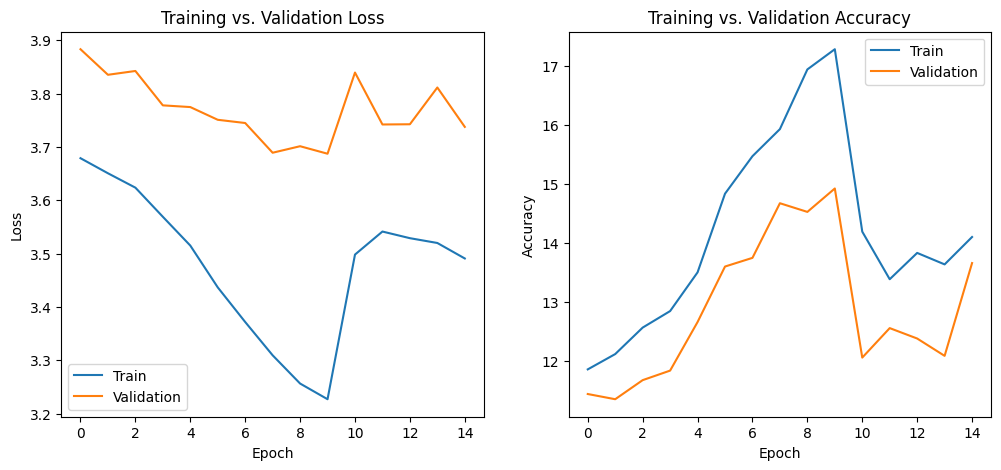

Accuracy: 0.1009
F1 Score: 0.0842
Precision: 0.0903
Recall: 0.1009
time: 4min 57s (started: 2025-03-08 11:59:48 +02:00)


/Users/yoavgal/code/car-classification/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
epochs=15 #60
lr=1e-3

optimizer = optim.AdamW(bigger_model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

train_loss, val_loss, train_acc, val_acc = training_loop(
    bigger_model, optimizer, criterion, epochs, train_loader, val_loader,scheduler=scheduler, is_clip=True,none_blocking=True)

visualize_results(train_loss, val_loss, train_acc, val_acc)
accuracy, f1, precision, recall = generate_classification_report(bigger_model, test_loader, device)


In [40]:
model_filename = f"last-exp-3-reust-{accuracy:.2f}"
save_best_model(bigger_model,model_filename)

Model saved to /Users/yoavgal/code/car-classification/CNN-notebook/./saved_models/last-exp-3-reust-0.10
time: 69.4 ms (started: 2025-03-08 12:05:00 +02:00)


# Save Model
In this section, we will:
- Save the best performing model
- Document the model architecture and hyperparameters
- Prepare the model for deployment or future use

In [512]:
model_filename = "small_cnn_exp_2"
save_best_model(small_cnn_exp_2,model_filename)

Model saved to /Users/yoavgal/code/car-classification/CNN-notebook/./saved_models/small_cnn_exp_2
time: 60 ms (started: 2025-03-07 00:38:52 +02:00)


# Test Model
In this section, we will:
- Evaluate the final model on the test dataset
- Generate classification reports and confusion matrices
- Visualize the model's predictions on sample images
- Discuss the strengths and weaknesses of our approach